In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import scipy
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu

%matplotlib inline

# Анализ исходных данных

Представьте, что вы работаете в крупном дейтинговом приложении. Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

В целях упрощения понимания всех исходных данных приведем их к общему обозначению. В качестве исходных данных были представлены три группы пользователей, которые разделены на тестовую группу и две контрольных.
-  Пользователи тестовой группе  - B
-  Пользователи в первой контрольной группе - А1
-  Пользователи во второй контрольной группе - А2

Для проверки данного эксперимента построим следующий план действий.
1. Проверка исходных данных на наличие пустых значений, дубликатов.
2. Произведем анализ групп А1 и А2, одинаковые ли выборки, есть ли расхождения по признакам в группах.
3. Проверка эксперимента, есть ли существенные отличия между группами А1,А2 и группой Б. Был ли проведен эксперимент достоверно
4. При успешном проведении эксперимента, определим какие группы вызывают отличия или таковых нет. В случае отрицательного проведения эксперимента выявим причину по который он не состоялся. 

Стоит сразу же предположить, что должно получиться на выходе. Логично предположить, что в случае успеха должны быть повышены такие метрики как: выручка, повышения числа пользователей с подпиской, ARPPU.

In [2]:
# информация о пользователях в тестовой группе. 
users_test = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-lygin/users_test.csv", sep=";")
# информация о пользователях в первой контрольной группе.
users_control_1 = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-lygin/users_control_1.csv", sep=";")
# информация о пользователях во второй контрольной группе .
users_control_2 = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-lygin/users_control_2.csv", sep=";")
# информация о платежах пользователей в тестовой группе. 
transactions_test = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-lygin/transactions_test.csv", sep=";",
    parse_dates=['joined_at','paid_at'])
# информация о платежах пользователей в первой контрольной группе. 
transactions_control_1 = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-lygin/transactions_control_1.csv", sep=";",
    parse_dates=['joined_at','paid_at'])
# информация о платежах пользователей во второй контрольной группе
transactions_control_2 = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-lygin/transactions_control_2.csv", sep=";",
    parse_dates=['joined_at','paid_at'])

In [3]:
# создадим копию для удобства, так как была необходимость проверки с исходными данными в дальнейшем
Copy_transactions_control_1 = transactions_control_1.copy()
Copy_transactions_control_2 = transactions_control_2.copy()
Copy_transactions_test = transactions_test.copy()

### Проведем обработку информации о группе Б

In [4]:
users_test.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [5]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [6]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [7]:
users_test.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
mean,8.917437e+08,31.889276,316.411328,229.836735,0.953110,26.701486,38.248839,50.391133,1.0,1.0,534.080316
std,4.547670e+05,10.245287,323.373725,1205.819471,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4371.682632
min,8.910511e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.0,1.0,129870.000000


In [8]:
# проверим на уникальность пользователей
users_test.uid.nunique()

4308

In [9]:
users_test.age.value_counts().head(5)

25    238
27    224
29    213
21    193
26    191
Name: age, dtype: int64

In [10]:
# для доп.проверки, сделаем сверку на дубликаты - они не были обнаружены
users_test.duplicated().value_counts()

False    4308
dtype: int64

### Проведем обработку транзакция группы Б

In [11]:
transactions_test.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [12]:
# было замечено, что тип данных "дата" не установился для ряда колонок, поэтому при загрузке данных
# будет добавлен соотвествующий параметр
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


In [13]:
# всего было 273 транзакции но уникальных пользователей всего 146 - возможно есть дубликаты стоит посмотреть
transactions_test.uid.nunique()

146

In [14]:
# потверждение что ряд пользователей сделали больше одной покупки, посмотрим подробнее на них 
transactions_test.uid.value_counts().head(5)

892236423    14
892065108     9
892339626     9
892057347     9
891174411     6
Name: uid, dtype: int64

In [15]:
# замечаем что есть ряд идентичных строк, что говорит о дубликатах стоит сделать проверку на дубликаты (2 и 55 строка)
# возможно при тесте это учли - а может и нет. Для чистоты эксперимента уберем их
one_order = transactions_test.query('uid == 892236423')
one_order.sort_values("paid_at")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
125,892236423,United States of America,2017-10-18 01:09:00,2017-10-18 01:15:00,6292,147,left_sidebar_menu,premium_no_trial
238,892236423,United States of America,2017-10-18 01:09:00,2017-10-18 01:33:00,1261,19,empty_likes,coins
17,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
139,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,3783,67,empty_likes,other_type
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
214,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,6305,19,empty_likes,coins
112,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:09:00,12610,19,empty_likes,coins
81,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,31525,19,menu,coins
98,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,12610,19,menu,coins
167,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,3783,67,menu,other_type


In [16]:
# видим наличие дубликатов, от них нужно избавиться - обнаружено 7 штук
transactions_test.duplicated().value_counts()

False    266
True       7
dtype: int64

In [17]:
transactions_test.isnull().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [18]:
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [19]:
transactions_test = transactions_test.drop_duplicates()
transactions_test.describe()

,uid,revenue,payment_id
count,2.660000e+02,266.000000,266.000000
mean,8.918302e+08,8767.766917,99.951128
std,3.775858e+05,11216.235341,57.409892
min,8.910712e+08,533.000000,0.000000
25%,8.914994e+08,3129.750000,19.000000
50%,8.918935e+08,6363.500000,146.000000
75%,8.920979e+08,12597.000000,147.000000
max,8.924386e+08,113477.000000,147.000000


### Проведем проверку исходных данных группы А1

In [20]:
users_control_1.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [21]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [22]:
users_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [23]:
users_control_1.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,60.0000,4340.000000,4340.000000,4340.000000,4340.000000,436.0,192.0,4340.000000
mean,8.917578e+08,32.095392,312.048848,1745.9000,0.958065,26.793779,38.553226,44.467512,1.0,1.0,594.761982
std,1.125683e+06,10.257466,320.972130,12902.3577,0.200465,9.405103,15.226951,204.800272,0.0,0.0,7987.922925
min,8.910510e+08,16.000000,0.000000,1.0000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913626e+08,24.000000,0.000000,8.0000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917272e+08,30.000000,238.500000,11.5000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920898e+08,38.000000,518.000000,28.0000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,9.609370e+08,99.000000,1000.000000,99958.0000,1.000000,96.000000,102.000000,4953.000000,1.0,1.0,486330.000000


In [24]:
# проверим на уникальность пользователей - все значения уникальны
users_control_1.uid.nunique()

4340

In [25]:
# на первый взгляд возраст похож на группу B
users_control_1.age.value_counts().head(5)

25    227
27    212
26    195
21    186
23    184
Name: age, dtype: int64

In [26]:
# сделаем сверку на дубликаты
users_control_1.duplicated().value_counts()

False    4340
dtype: int64

### Проведем обработку транзакция группы А1

In [27]:
transactions_control_1.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [28]:
# стоит посмотреть количество строк и дубликатов
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


In [29]:
transactions_control_1.uid.nunique()

193

In [30]:
# аналогично получаем большое количество покупок от ряда пользователей
transactions_control_1.uid.value_counts().head(5)

892333905.0    27
892069554.0    11
891707061.0    10
892366260.0    10
891367521.0    10
Name: uid, dtype: int64

In [31]:
# замечаем что есть ряд идентичных строк с полнотьсью одинаоквыми значениями (строка 76 и 359) - дубликаты?
o_order = transactions_control_1.query('uid == 892333905 ')
o_order.sort_values("paid_at")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
49,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type
13,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
28,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type
296,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type
43,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
198,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
6,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins


In [32]:
# при удалении такого количество дубликатов размер группы будет сопостовим с группой B
transactions_control_1.duplicated().value_counts()

True     650
False    357
dtype: int64

In [33]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [34]:
# произведем очистку от всего
transactions_control_1 = transactions_control_1.drop_duplicates()
transactions_control_1 = transactions_control_1.dropna()
# переведем колонку к нужному типу
transactions_control_1.uid = transactions_control_1.uid.astype(int)

In [35]:
transactions_control_1.describe()

,uid,revenue,payment_id
count,3.560000e+02,356.000000,356.000000
mean,8.923874e+08,7007.876404,93.985955
std,6.340717e+06,7985.995094,58.491673
min,8.910923e+08,26.000000,0.000000
25%,8.914030e+08,2804.750000,19.000000
50%,8.918225e+08,6292.000000,146.000000
75%,8.921662e+08,7312.500000,147.000000
max,9.609370e+08,63037.000000,147.000000


### Проведем проверку исходных данных группы А2

In [36]:
users_control_2.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [37]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [38]:
users_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

In [39]:
users_control_2.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,61.000000,4264.000000,4264.000000,4264.000000,4264.000000,411.0,191.0,4264.000000
mean,8.917694e+08,32.046201,317.957317,18.147541,0.954268,26.954268,38.906895,45.064493,1.0,1.0,450.384146
std,2.520759e+06,10.170721,326.191737,35.439543,0.208927,9.546657,15.955574,318.188992,0.0,0.0,2859.242228
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913453e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917205e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920735e+08,38.000000,548.500000,20.000000,1.000000,32.000000,45.000000,20.000000,1.0,1.0,0.000000
max,1.053059e+09,99.000000,1000.000000,271.000000,1.000000,94.000000,99.000000,16157.000000,1.0,1.0,81796.000000


In [40]:
# проверим на уникальность пользователей - все значения уникальны
users_control_2.uid.nunique()

4264

In [41]:
# основная группа пользователей схожа с группами А1, B
users_control_2.age.value_counts().head(5)

25    241
27    226
24    189
26    185
29    173
Name: age, dtype: int64

In [42]:
# для дополнительной проверки, сделаем сверку на дубликаты
users_control_2.duplicated().value_counts()

False    4264
dtype: int64

### Проведем обработку транзакция группы А2

In [43]:
transactions_control_2.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [44]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


In [45]:
transactions_control_2.uid.nunique()

187

In [46]:
transactions_control_2.uid.value_counts().head(5)

891637005    11
892230228    10
891080040     8
892139829     6
892435536     5
Name: uid, dtype: int64

In [47]:
# замечаем что есть ряд идентичных строк - аналогичная проблема выявленная ранее
o2_order = transactions_control_2.query('uid == 891637005 ')
o2_order.sort_values("paid_at")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
292,891637005,Spain,2017-10-30 15:22:00,2017-02-11 13:38:00,6292,147,left_sidebar_menu,premium_no_trial
279,891637005,Spain,2017-10-30 15:22:00,2017-02-11 13:39:00,6396,147,left_sidebar_menu,premium_no_trial
30,891637005,Spain,2017-10-30 15:22:00,2017-02-11 13:48:00,3783,67,gifts,other_type
255,891637005,Spain,2017-10-30 15:22:00,2017-02-11 13:48:00,6305,19,gifts,coins
209,891637005,Spain,2017-10-30 15:22:00,2017-10-30 15:48:00,3783,67,menu,other_type
167,891637005,Spain,2017-10-30 15:22:00,2017-10-30 15:53:00,1261,19,gifts,coins
161,891637005,Spain,2017-10-30 15:22:00,2017-10-30 15:57:00,1261,19,autorefill,coins
82,891637005,Spain,2017-10-30 15:22:00,2017-10-30 15:59:00,1261,19,autorefill,coins
271,891637005,Spain,2017-10-30 15:22:00,2017-10-30 16:00:00,1261,19,autorefill,coins
166,891637005,Spain,2017-10-30 15:22:00,2017-10-30 16:08:00,1261,19,autorefill,coins


In [48]:
transactions_control_2.duplicated().value_counts()

False    323
True       5
dtype: int64

In [49]:
# очистка
transactions_control_2 = transactions_control_2.drop_duplicates()

In [50]:
transactions_control_2.describe()

,uid,revenue,payment_id
count,3.230000e+02,323.000000,323.000000
mean,8.918091e+08,5907.111455,96.563467
std,3.822411e+05,6615.180325,57.024988
min,8.910681e+08,481.000000,0.000000
25%,8.915462e+08,2340.000000,19.000000
50%,8.918570e+08,4719.000000,146.000000
75%,8.921281e+08,6350.500000,147.000000
max,8.924388e+08,81796.000000,147.000000


In [51]:
# дополнительно проверим на наличие пустых значений
transactions_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

## Итоги предобработки данных
- Информация о пользователях в тестовой группе содержится корректно, все типы данных соответствуют ожидаемым, есть пустые значения по столбцам coins, visit_days, was_premium, is_premium. По данным столбцам это вполне может быть, так как монеты могут быть или нет, зависит от активности пользователя, аналогично и наличие или использование премиум подписки, дни когда пользователь был онлайн, также могут быть пустыми, так как пользователь мог скачать и забыть про данное приложение. Все пользователи уникальны и важные поля по ним заполнены. По первой таблице на первый взгляд вопросов не возникает. 
- Информация о транзакциях в тестовой группе содержится корректно, но были изменены типы данных по двум колонкам с датами. Также в ходе анализа транзакций было замечено, что уникальных всего 146 из 273, что говорит о том, что некоторые пользователи совершали две и более покупок. В дальнейшем следует обратить на это внимание. Также были обнаружены дубликаты, в размере 7 строк у ряда подозрительных пользователей, которые были удалены.
- Информация о пользователях в группе А1 содержится корректно, есть поля которые не заполнены, но они также как и в группе Б поддаются объяснению аналогично, описанному ранее. По первому восприятию, возраст в группах А1 и Б похож, что может дать положительный сигнал о проведении теста.
- Информация о транзакциях в группе А1 содержится с ошибками, типы данных частично нарушены, явное присутствие дубликатов и пропусков, большой разрыв между реальными пользователями и всем числом транзакций. Также сразу бросается факт объёма транзакций по сравнению с группой Б, 300+ против 250.
- Информация о пользователях в группе А2 содержится корректно, пропущенные значения аналогичный предыдущим двум группам и поддаются логическому объяснению. По первому взгляду данные схожи с двумя другими группами, что может косвенно подтверждать о правильность эксперимента.
- Информация о транзакциях в группе А2 содержится c аналогичными ошибками как и группа А1, которые были исправлены, также были обнаружены дубликаты и была проведена их очистка. Размерность данных на первый взгляд схожа с теми, которые были исследованы ранее.

### Вывод: на первый взгляд структура, размерность, типы данных у групп А1, А2, B схожи. В процессе обработки были получены одинаковые ошибки в каждом датасете. На данном этапе можно предположить, что эксперимент мог быть проведен корректно, но есть множество вопросов по исходным данным и наличии большого числа различных аномалий. Поэтому для чистоты эксперимента, будут использованы исключительно очищенные данные - чтобы избежать ошибки, так как при наличии дубликатов они могут изменить метрики, что даст ложный результат. Но в дальнейшем будет произведена проверка с исходными значениями, чтобы убедиться, что целостность данных не была нарушена.


# Проверка А/А теста

Для проверки корректности проведения А/А/Б теста необходимо сначала проверить систему сплитирования которая основана на группах А1 и А2, которые в свою очередь составляют основу для А/А теста. Так как нас интересует в целом только полученная прибыль в ходе следующего эксперимента, то нужно сверить размерность данных, критерии двух групп и различия по выручке между ними. Выяснить на сколько они статистически различаются и в случае если различия между ними нет, то можно будет приступить к проверки самого эксперимента.
1.	Объединение информации о клиентах и транзакциях. Так как в EDA не было прямой необходимости объединять, то сейчас будет произведено объединение информации и транзакции
2.	Сравнение признаков и размерности. Поиск выбросов и аномалий, проверка статистических гипотез
3.	Использование статистических методов для сравнения целевого показателя "revenue" между двумя выборками

In [52]:
print("Размерность информации о клиентах группы А1:", users_control_1.shape)
print("Размерность транзакций группы А1:", transactions_control_1.shape)
print("--------------------------------------------------------------")
print("Размерность информации о клиентах группы А2:", users_control_2.shape)
print("Размерность транзакций группы А2:", transactions_control_2.shape)

Размерность информации о клиентах группы А1: (4340, 13)
Размерность транзакций группы А1: (356, 8)
--------------------------------------------------------------
Размерность информации о клиентах группы А2: (4264, 13)
Размерность транзакций группы А2: (323, 8)


In [53]:
A1_frame = users_control_1.merge(transactions_control_1, how = 'right', on = 'uid')
A2_frame = users_control_2.merge(transactions_control_2, how = 'right', on = 'uid')
# проверим не потерялись ли какие транзакции при обьединении
print("A1:", A1_frame.shape)
print("A1:", A2_frame.shape)

A1: (356, 20)
A1: (323, 20)


In [54]:
# количество уникальных пользователей по каждой группе - они немного разняться, но не критично.
print("A1:", A1_frame.uid.nunique())
print("A2:", A2_frame.uid.nunique())

A1: 193
A2: 187


In [55]:
# так как в условии есть четкое понятие что раскатили фичу на каких то странах, то нужно понять на каких и сколько их всего
A1_frame.country_x.value_counts()

United States of America          100
Italy                              54
France                             37
United Kingdom (Great Britain)     30
Argentina                          27
Israel                             21
Chile                              15
Canada                             14
Spain                              14
United Arab Emirates               12
Germany                             7
Turkey                              6
Belgium                             4
Portugal                            4
Australia                           3
Russian Federation                  3
Switzerland                         3
India                               2
Name: country_x, dtype: int64

In [56]:
# сразу можно заметить что страны отличаются, посмотрим более подробно
A2_frame.country_x.value_counts()

United States of America          105
Italy                              31
Spain                              25
France                             23
United Kingdom (Great Britain)     20
Israel                             19
Chile                              19
Argentina                          18
Belgium                            14
Portugal                           11
Germany                             7
Canada                              6
United Arab Emirates                6
Switzerland                         5
Turkey                              4
Austria                             3
Australia                           3
Ukraine                             3
Lithuania                           1
Name: country_x, dtype: int64

In [57]:
# количество уникальных стран по каждой группе - количество стран разное, так еще и в составе разные страны. 
# возможно значения были утрачены в процессе обработки как строки с Nan, для доставерности надо проверить это
print("Обработанные данные A1: ", A1_frame.country_x.nunique())
print("Обработанные данные A2: ", A2_frame.country_x.nunique())

Обработанные данные A1:  18
Обработанные данные A2:  19


In [107]:
print("Исходные данные без предобработки A1: ", Copy_transactions_control_1.country.nunique())
print("Исходные данные без предобработки A2: ", Copy_transactions_control_2.country.nunique())

Исходные данные без предобработки A1:  18
Исходные данные без предобработки A2:  19


In [59]:
# так как в исходных данных присутсвует пол, то необходимо проверить соотнощение полов
A1_frame.gender.value_counts()

1    352
0      4
Name: gender, dtype: int64

In [60]:
# из результатов видно неравенство между полами, но оно одинаково между группами А1, А2
A2_frame.gender.value_counts()

1    316
0      7
Name: gender, dtype: int64

In [108]:
print("Среднее значение выручки А1: ", A1_frame.revenue.mean())
print("Среднее значение выручки А2: ", A2_frame.revenue.mean())

Среднее значение выручки А1:  7007.876404494382
Среднее значение выручки А2:  5907.111455108359


In [62]:
# посмотрим тогда и на даты начала эксперемента в группе А1 и группе А2 - Группа А1
print ("Самая первая дата оплаты в А1: ",A1_frame.paid_at.min())
print ("Самая последня дата оплаты в А1: ",A1_frame.paid_at.max())

Самая первая дата оплаты в А1:  2016-12-14 16:16:00
Самая последня дата оплаты в А1:  2017-12-11 21:57:00


In [63]:
# дата начала эксперемента отличается, возможно стоит убрать данные из эксперемента, но пока не будет торопиться с этим
# Группа А2
print ("Самая первая дата оплаты в А2: ",A2_frame.paid_at.min())
print ("Самая последня дата оплаты вА2: ",A2_frame.paid_at.max())

Самая первая дата оплаты в А2:  2017-01-11 05:34:00
Самая последня дата оплаты вА2:  2017-12-11 23:28:00


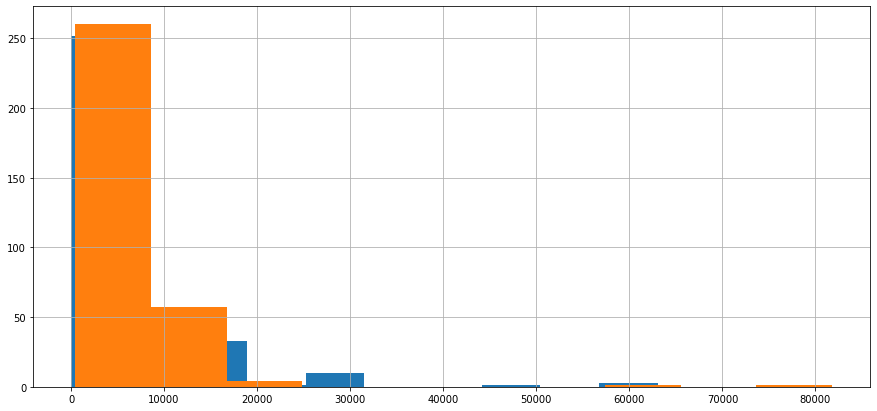

In [64]:
# по диаграмме можно сказать, что распределение отличается от нормального, но проверим статистически
# есть выбросы которые наглядно видно, но воспользуемся другими средства визуализации их
fig = plt.figure(figsize = (15,7))
A1_frame.revenue.hist()
A2_frame.revenue.hist()

In [65]:
#  p-val очень мал, это означает, что маловероятно, что данные получены из нормального распределения
print("А1: ",scipy.stats.normaltest(A1_frame.revenue))
print("А2: ",scipy.stats.normaltest(A2_frame.revenue))

А1:  NormaltestResult(statistic=336.601384370965, pvalue=8.0898055592393e-74)
А2:  NormaltestResult(statistic=455.8905262909609, pvalue=1.0107180925324292e-99)


На графике есть выбросы и в дальнейшем они могут сильно изменить картину, есть несколько вариантов решения:
    1. Использовать методы, которые устойчивы к выбросами 
    2. Удалять из выборок выбросы и использовать
    Выборки и так содержат не так много значений после обработки, а выбросов окажется около 10-20 значений, прям сразу уменьшать выборку не очень хочется, поэтому используем первый вариант, при необходимости и наличии времени, проверим и второй вариант уже в отдельном файле для тестов, чтобы не занимать место тут.

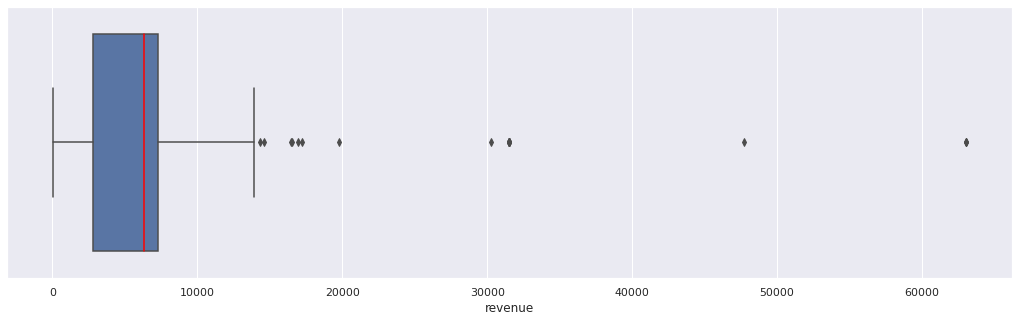

In [66]:
# с помощью визуализации будет понятнее
sns.set(rc={'figure.figsize':(18,5)})
sns.boxplot(x = A1_frame['revenue'], medianprops={"color": "red"})

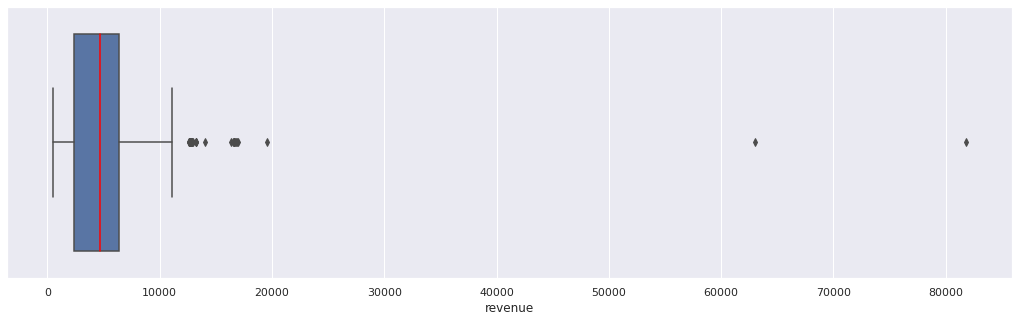

In [67]:
sns.set(rc={'figure.figsize':(18,5)})
sns.boxplot(x = A2_frame['revenue'], medianprops={"color": "red"})

При аналитике данных, можно заметить, что было много "неточностей", но не проверить статистически распределения нельзя, поэтому проверим pvalue с помощью нескольких методов и сравним результаты, после чего сделаем выводы. Если распределение признака отличается от нормального как это сейчас видно, можно использовать непараметрический аналог – U-критерий Манна-Уитни. Он переводит все данные в ранговую шкалу, после этого считает какой средний ранг оказался в первой группе и какой во второй. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов.
Также стоит сразу обозначить что мы будем принимать, а что отклонять. Гипотеза H(0) - разница между А1 и А2 в разрезе "revenue" нет. Гипотеза H(1) - разница между А1 и А2 есть.
Значение pvalue > 0,5 следовательно "revenue" не отличается значимо между группами А1 и А2, но нужно проверить еще, так как на практике показания одного теста могут значимо отличаться от другого для теста Манна-Уитн. 

Примечание: выбор метод был обоснвал чуть дальше в рамках вставленной фотографии-схемы


In [68]:
mannwhitneyu(A1_frame.revenue, A2_frame.revenue )  

MannwhitneyuResult(statistic=61782.0, pvalue=0.0923730775121966)

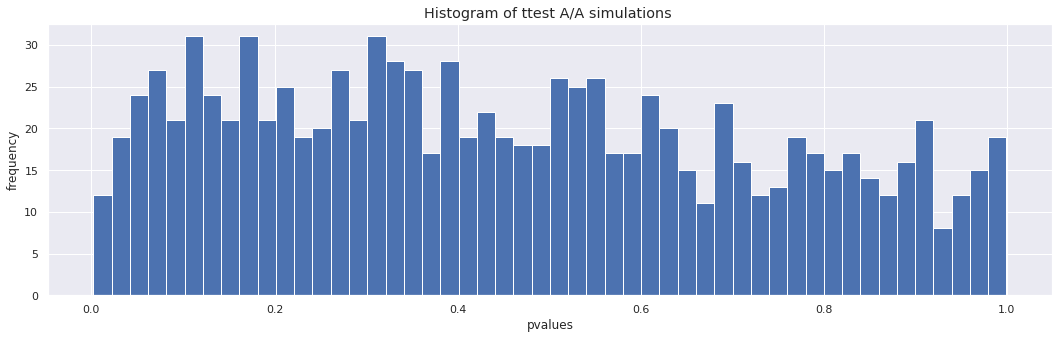

0.042

In [69]:
# для проверки качества сплитовалки считаем долю ложноположительных оценок (FPR): из графика видно, что есть области которые 
# равномерно распределены. Данный тест, позволяет сказать что сплитирование прошло успешно. 
# но в целом он не иделен, так как график все таки имеет наклон. 

n = 400
simulations = 1000
n_s = 20
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = A1_frame['revenue'].sample(n_s, replace = False).values
    s2 = A2_frame['revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

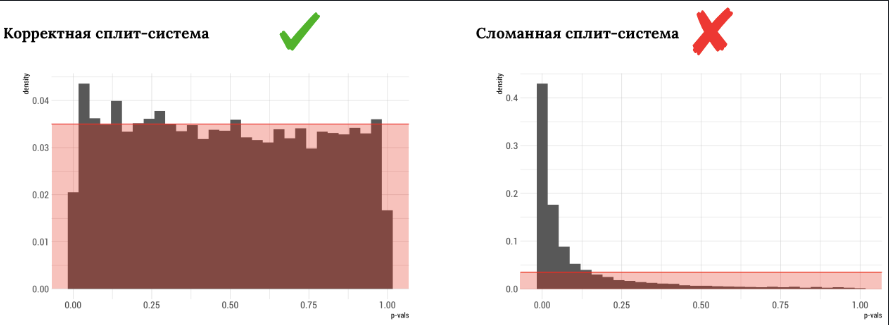

# Итоги А/А теста
1.	Выборки оказались не идеальными и имеют множество условностей начиная от размера, разными странами, довольно неоднозначным распределением полов и заканчивая выбросами в группах А1, А2. Также иммеется вопрос по датам начала эксперемента, но пока этот момент был опущен,в дальнейшем при проверки групп с В будет учтен.
2.	Обе группы и их распределения отличаются от нормального, это было видно и на графике, и с помощью значений теста. Поэтому это осложнило выбор методов сравнения ключевого показателя прибыли, который нас интересует
3.	Исходя из полученного ранее опыта то для проверка использовались два метода: FPR(который был описан в рамках курса) и непараметрический аналог – U-критерий Манна-Уитни. При изменении размера выборок и симуляций при использовании FPR - результаты были репрезентативны и однозначны. Выборки не имеют различий по выборки и А/А тест был проведен корректно.
Примечание: тем не менее при верном теста, сам по себе он был сделан не очень качественно из-за данных, которые желательно должны были иметь меньше проблем.




# Проверка А/А/B теста
Так как система сплитирования прошла проверку, теперь нужно провести А/B тест и выявить различия между группами. Для этого поставим следующие задачи:
1. Объединить тестовую группу(информацию и транзакции), посмотреть размерность и соотнести группы А/А/B
2. Произвести аналогичный статистический анализ для группы B, является ли распределение нормальным, есть ли выбросы, какие группы стран и полов задействованы.
3. Произвести поочередное сравнение групп A1/B и A2/B, затем проверить A1+A2/B, на основе чего сделать вывод, при наличии статистических различий произвести детальный анализ по категориям.


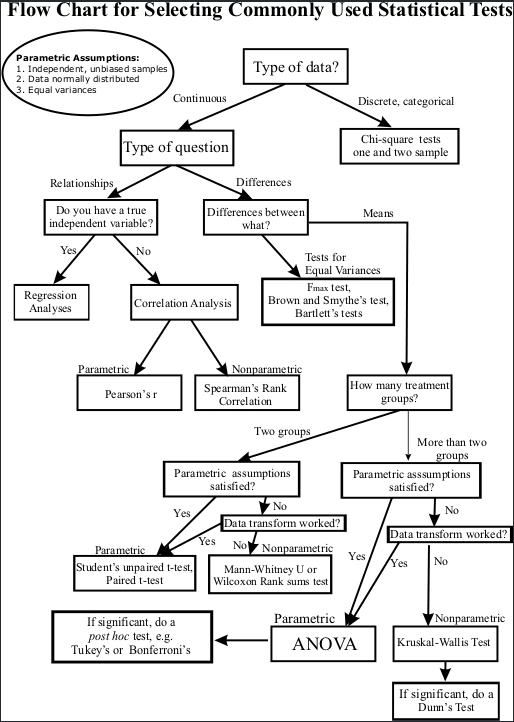

In [70]:
# проверим размерность на возможность потерь
B_frame = users_test.merge(transactions_test, how = 'right', on = 'uid')
B_frame.shape

(266, 20)

In [71]:
# В обоих случаях pvalue < 0, следовательно группы А1 и А2 так или иначе отличаются от B
print("Сравнение А1/B:",mannwhitneyu(A1_frame.revenue, B_frame.revenue))
print("Сравнение А2/B:",mannwhitneyu(A2_frame.revenue, B_frame.revenue))

Сравнение А1/B: MannwhitneyuResult(statistic=40815.0, pvalue=0.003195927321978535)
Сравнение А2/B: MannwhitneyuResult(statistic=34220.0, pvalue=2.0938846344776575e-05)


Бутстрап позволяет строить доверительный интервал для любого параметра распределения, не применяя для этого аналитическую формулу. Основное преимущество Бутстрапа — возможность проверять гипотезы для любых параметров распределения или модели: перцентилей, квантилей, децилей и т.п. Бутстрап проверяет статистические гипотезы без опоры на определённое теоретическое распределение данных (в отличие от классических статистических критериев). Бутстрап позволяет сделать оценку любого «сложного» параметра путём нахождения доверительных интервалов для него. А для проверки гипотез — путём вычисления их разницы.

In [72]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

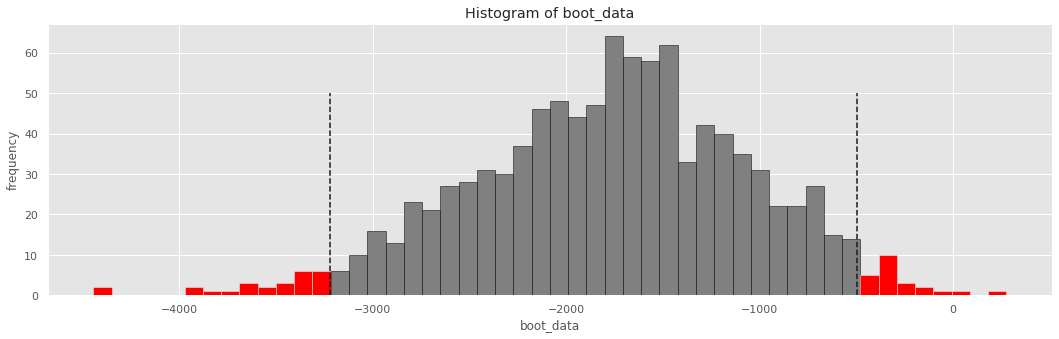

In [73]:
booted_data = get_bootstrap(A1_frame.revenue,B_frame.revenue) # в результате хранится разница двух распределений, ДИ и pvalue

In [74]:
print("p-value:",booted_data["p_value"]) # альфа

p-value: 0.012444611525024423


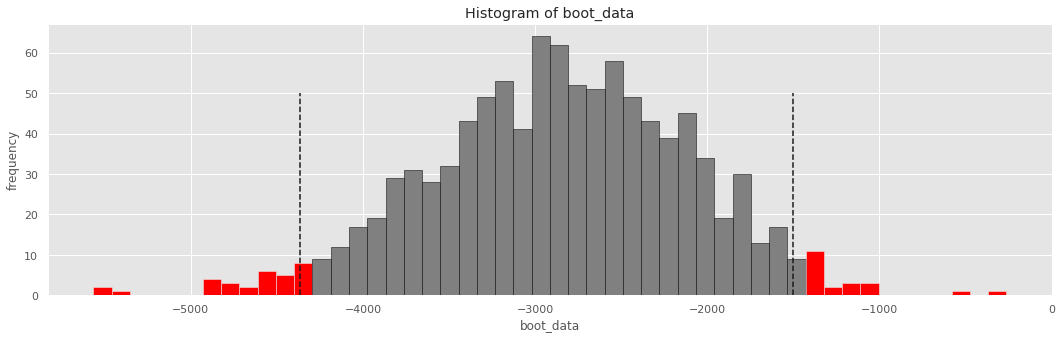

In [75]:
booted_data2 = get_bootstrap(A2_frame.revenue, B_frame.revenue)

In [76]:
print("p-value:",booted_data2["p_value"]) # альфа

p-value: 0.00012408992323986262


In [77]:
# для достоверности проверим еще А1 + А2/B
А1_rev, А2_rev  = A1_frame.revenue.to_frame(), A2_frame.revenue.to_frame() 
# сделаем общий столбец по "revenue"
А12_rev = pd.concat([А1_rev, А2_rev], ignore_index=True)

In [78]:
print("Сравнение А1/А2/B:",mannwhitneyu(А12_rev.revenue, B_frame.revenue))

Сравнение А1/А2/B: MannwhitneyuResult(statistic=75035.0, pvalue=5.0927830386404524e-05)


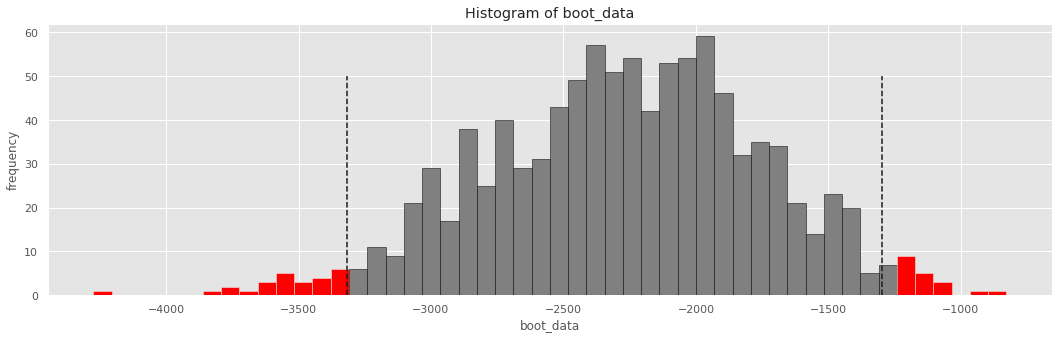

In [79]:
booted_data_all = get_bootstrap(А12_rev.revenue, B_frame.revenue)

In [80]:
print("p-value:", booted_data_all["p_value"]) # альфа

p-value: 1.1024743893693459e-05


# Итоги проверки А/А/B теста
В ходе проверки можно сделать вывод что тестирование прошло успешно и действительно между контрольными и тестовой группой есть значимые статистические различия. Стоит отметить, что в ходе поочередного значения одна группа показала большее отличие чем другая контрольная выборка. Группа А2 имеет более явные выраженные отличия, чем группа А1, в дальнейшем и будет ее использовать для анализа. В ходе проверки были использованы следующие методы: непараметрический аналог – U-критерий Манна-Уитни и бустрап, так как исходя из полученных ранее знаний с опорой на предложенную выше схему, они наиболее оптимально подходят для выполнения поставленной задачи. Выделим результаты:
Выделим результаты:
 - U-критерий Манна-Уитни: 
         Сравнение А1/B: pvalue=0.003195927321978535
         Сравнение А2/B: pvalue=2.0938846344776575e-05
         Сравнение А1+А2/B: pvalue=5.0927830386404524e-05
   pvalue < 0, следовательно группы А1 и А2 отличаются от B
 - Бутстрап: 
         Сравнение А1/B: p-value: 0.013190376173479958
         Сравнение А2/B: p-value: 5.817130407183957e-05
         Сравнение А1+А2/B: p-value: 6.7741855302845956e-06
   pvalue > 0, следовательно группы А1 и А2 отличаются от B

# Поиск изменений в группах  А/А/B теста
Так как тест прошел успешно, следует провести анализ, в каких сегментах пользователей есть значимые отличия. В качестве первоначальных идей для анализа можно разделить пользователей на сегменты(кроме пола, так как преимущество в данных один пол и просто не имеет смысла искать разницу по полам) а вот использовать страны и возраст и различе параметры аккаунта вполне можно. 
1. Провести  сравнения по странам(просуммировать прибыль по странам до и после, в какой стране прирост или убыток изменился больше всего
2. Разделить пользователей на возрастные группы, так как отслеживать каждый возраст слишком трудозатратно, например взять по 10–15  лет разницу как новое поколение
3. Так как ранее параметры аккаунта типо монет, подписок не были рассмотрены, то следует более детально посмотреть, где и как значимо отличаются результаты.


In [81]:
# взглянем еще раз на данные
B_frame.head(3)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,52,209,NaN,Italy,"1,2,3,4,5,6,8,10",1,49,55,43,1.0,1.0,12909,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,37,390,NaN,United States of America,"1,2,3,4,6,7",1,34,40,64,1.0,1.0,13923,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


In [82]:
A1_frame.head(3)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275,27,0,NaN,France,"1,2,3",1,24,30,2,1.0,1.0,13455,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,891319275,27,0,NaN,France,"1,2,3",1,24,30,2,1.0,1.0,13455,France,2017-05-11 19:57:00,2017-05-11 20:05:00,728.0,146.0,ad_to_photo,coins
2,892421826,31,43,NaN,Israel,"1,2,4,6,7,10,11,12,13,14,15,17,18,19,20,21,22,...",1,28,34,69,1.0,1.0,14586,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium


In [83]:
A2_frame.head(3)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,891266616,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902,Argentina,2017-06-11 15:25:00,2017-08-11 05:22:00,6305,19,empty_likes,coins
2,891266616,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902,Argentina,2017-06-11 15:25:00,2017-07-11 00:08:00,6292,147,promo_09,premium_no_trial


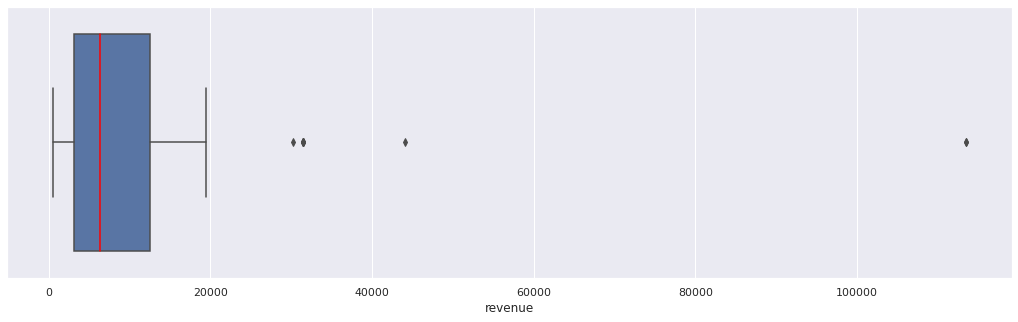

In [84]:
# посмотрим выбросы еще в группе В - аналогичный результаты
sns.set(rc={'figure.figsize':(18,5)})
sns.boxplot(x = B_frame['revenue'], medianprops={"color": "red"})

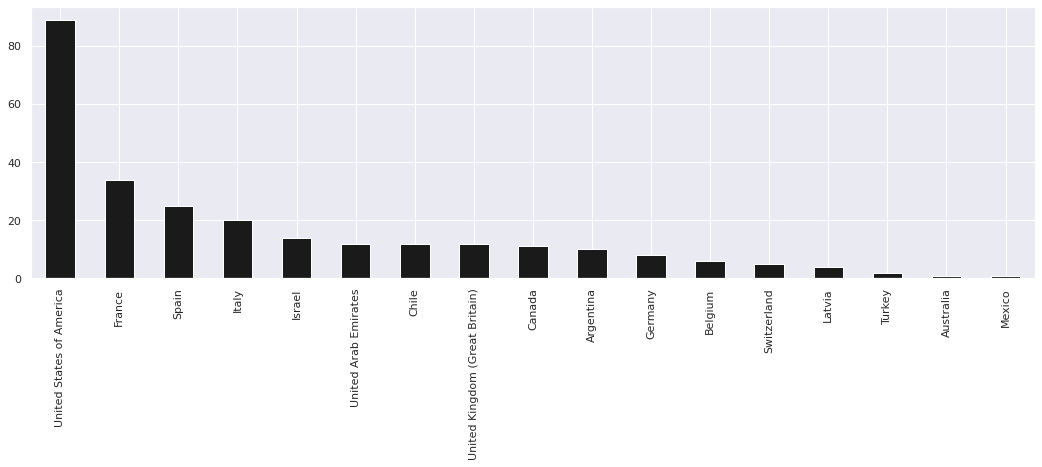

In [85]:
# посмотрим визуализацию по странам
plt.grid()
B_frame.country_x.value_counts().plot(kind="bar", color="k")

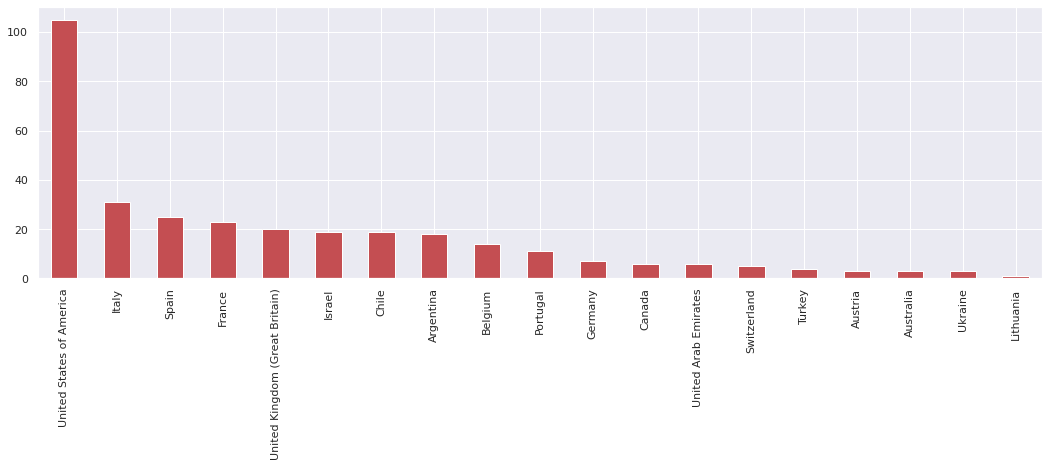

In [86]:
plt.grid()
A2_frame.country_x.value_counts().plot(kind="bar", color="r")

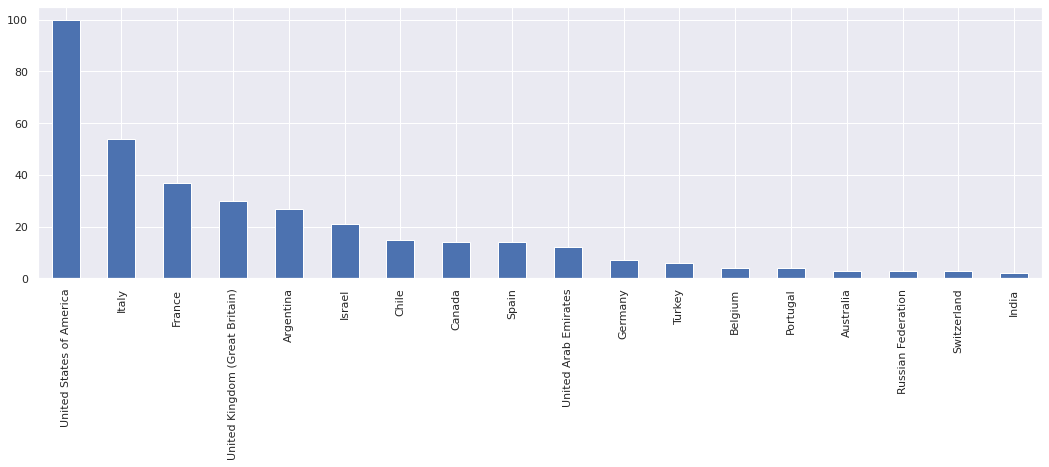

In [87]:
plt.grid()
A1_frame.country_x.value_counts().plot(kind="bar", color="b")

In [88]:
# так как страны различаются, возьмем только то что есть в группе B
B_revenue = B_frame.groupby(["country_x"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'B'})
A2_revenue = A2_frame.groupby(["country_x"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'A2'})
A1_revenue = A1_frame.groupby(["country_x"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'A1'})
Revenue = B_revenue.merge(A2_revenue, how = 'left', on = 'country_x')
Revenue = Revenue.merge(A1_revenue, how = 'left', on = 'country_x')
# есть пару не совпадений так как страны разные, уберем их сразу, они ничем не помогут
Revenue = Revenue.dropna()

In [89]:
# основная идея - посмотреть страны в которых в чистом виде выручка максимально сильно изменилась
Revenue["B_A2"] = Revenue.B - Revenue.A2
Revenue["B_A1"] = Revenue.B - Revenue.A1
# после нахождения разницы по каждой стране, можно выделить топ-3 страны где фича была успешнее всего применена
Revenue.sort_values(by=['B'], ascending=False)

,country_x,B,A2,A1,B_A2,B_A1
16,United States of America,711360,576641.0,727922.0,134719.0,-16562.0
5,France,297700,149071.0,181831.0,148629.0,115869.0
11,Spain,285428,193778.0,99060.0,91650.0,186368.0
14,United Arab Emirates,213785,117143.0,75543.0,96642.0,138242.0
0,Argentina,188019,121017.0,143429.0,67002.0,44590.0
8,Italy,113425,115375.0,539786.0,-1950.0,-426361.0
6,Germany,96096,71409.0,23998.0,24687.0,72098.0
7,Israel,93548,67665.0,114608.0,25883.0,-21060.0
15,United Kingdom (Great Britain),77376,96473.0,198965.0,-19097.0,-121589.0
4,Chile,69940,108615.0,97565.0,-38675.0,-27625.0


In [109]:
print("Общая прибыль по группе B:",Revenue.B.sum())
print("Общая прибыль по группе A2:",Revenue.A2.sum())
print("Общая прибыль по группе A2:",Revenue.A1.sum())

Общая прибыль по группе B: 2316847
Общая прибыль по группе A2: 1820377.0
Общая прибыль по группе A2: 2464943.0


In [91]:
Revenue.sort_values(by=['B_A2'], ascending=False).head(3)

,country_x,B,A2,A1,B_A2,B_A1
5,France,297700,149071.0,181831.0,148629.0,115869.0
16,United States of America,711360,576641.0,727922.0,134719.0,-16562.0
14,United Arab Emirates,213785,117143.0,75543.0,96642.0,138242.0


In [92]:
Revenue.sort_values(by=['B_A1'], ascending=False).head(3)

,country_x,B,A2,A1,B_A2,B_A1
11,Spain,285428,193778.0,99060.0,91650.0,186368.0
14,United Arab Emirates,213785,117143.0,75543.0,96642.0,138242.0
5,France,297700,149071.0,181831.0,148629.0,115869.0


Перейдем к возрасту, необходимо выделить какие то группы и посмотреть также как по станам различия в выручке
чтобы выделить группы  - обратимся к возрастной переодизации 
https://ru.wikipedia.org/wiki/%D0%92%D0%BE%D0%B7%D1%80%D0%B0%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F

In [93]:
# напишем функцию, которая поможет определять возраст поделим на 4 группы: подростки до 18, моложежь до 35, до 60 средний
# и после уже пожилой возраст
def age_function(x):
    if x <= 18:
        return 1
    elif x >= 19 and x <= 35:
        return 2
    elif x >= 35 and x <= 60:
        return 3
    else:
        return 4

In [94]:
# сразу используем для всех исследуемых групп
B_frame['age_group'] = B_frame['age'].apply(age_function)
A2_frame['age_group'] = A2_frame['age'].apply(age_function)
A1_frame['age_group'] = A1_frame['age'].apply(age_function)

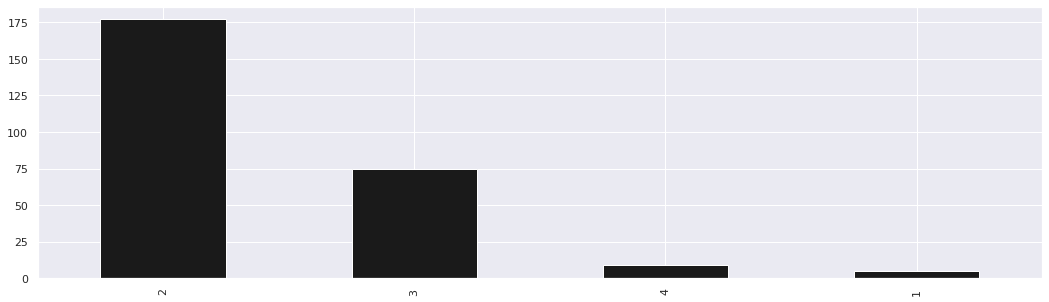

In [95]:
B_frame['age_group'].value_counts().plot.bar(color="k")

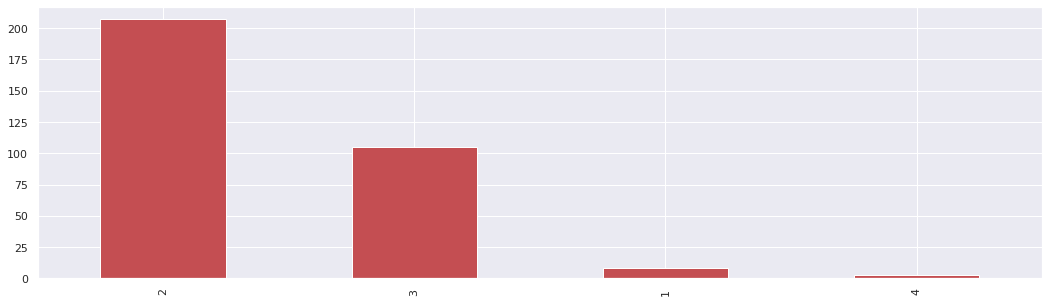

In [96]:
A2_frame['age_group'].value_counts().plot.bar(color="r")

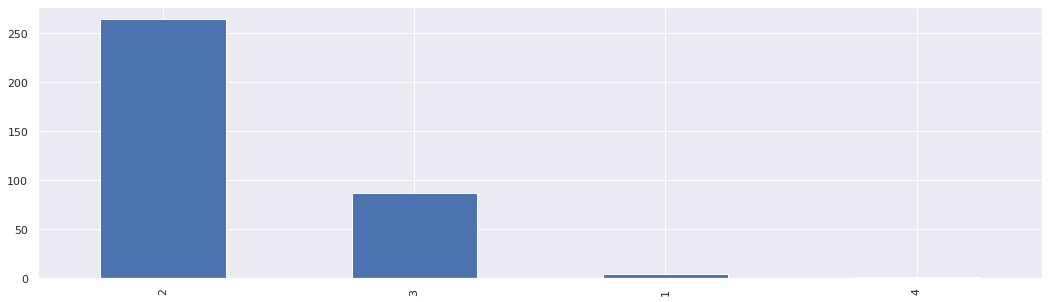

In [97]:
A1_frame['age_group'].value_counts().plot.bar(color="b")

In [98]:
# во всех трех случаях преобладает категория от 19 до 35 лет, это вполне логично, трудоспособное и еще активное население
# можно разбить группы более детально, но в целом средний возраст -  около 25 лет 


In [99]:
# теперь повторим похожую операцию и посмотрим прибыль от каждого контингента
B_age = B_frame.groupby(["age_group"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'B'})
А1_age = A1_frame.groupby(["age_group"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'A1'})
А2_age = A2_frame.groupby(["age_group"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'A2'})

In [100]:
age = B_age.merge(А1_age, how = 'left', on = 'age_group')
age = age.merge(А2_age, how = 'left', on = 'age_group')
age["B_A2"] = age.B - age.A2
age["B_A1"] = age.B - age.A1
age

,age_group,B,A1,A2,B_A2,B_A1
0,1,41262,9594.0,56355,-15093,31668.0
1,2,1482949,1859650.0,1213589,269360,-376701.0
2,3,760773,618228.0,629174,131599,142545.0
3,4,47242,7332.0,8879,38363,39910.0


In [101]:
age.sort_values(by=['B_A2'], ascending=False).head(1)

,age_group,B,A1,A2,B_A2,B_A1
1,2,1482949,1859650.0,1213589,269360,-376701.0


In [102]:
age.sort_values(by=['B_A1'], ascending=False).head(1)

,age_group,B,A1,A2,B_A2,B_A1
2,3,760773,618228.0,629174,131599,142545.0


In [103]:
B_product_type = B_frame.groupby(["product_type"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'B'})
A1_product_type = A1_frame.groupby(["product_type"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'A1'})
A2_product_type = A2_frame.groupby(["product_type"], as_index = False)  \
       .agg({'revenue' : 'sum'}).rename(columns={'revenue': 'A2'})
# обьеденим данные
product_type = B_product_type.merge(A1_product_type, how ='left', on='product_type')
product_type = product_type.merge(A2_product_type, how ='left', on='product_type')
# посчитаем разницу между группами В и А1/А2
product_type["B_A2"] = product_type.B - product_type.A2
product_type["B_A1"] = product_type.B - product_type.A1
product_type

,product_type,B,A1,A2,B_A2,B_A1
0,coins,561067,781482.0,392821,168246,-220415.0
1,other_type,160251,161343.0,126386,33865,-1092.0
2,premium_no_trial,810706,779259.0,744809,65897,31447.0
3,trial_premium,800202,772720.0,643981,156221,27482.0


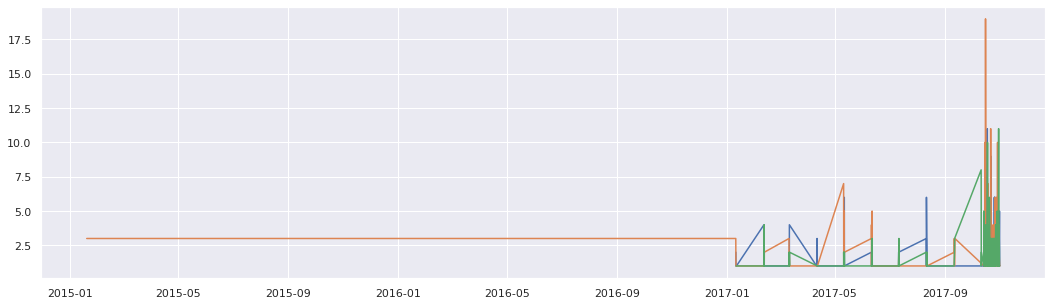

In [104]:
# посмотрим, увеличилось ли число регистраций при внедрении новой фичи
B_joined_at = B_frame.groupby(["joined_at"], as_index = False)  \
       .agg({'country_x' : 'count'}).rename(columns={'country_x': 'B'})
A1_joined_at = A1_frame.groupby(["joined_at"], as_index = False)  \
       .agg({'country_x' : 'count'}).rename(columns={'country_x': 'A1'})
A2_joined_at = A2_frame.groupby(["joined_at"], as_index = False)  \
       .agg({'country_x' : 'count'}).rename(columns={'country_x': 'A2'})
# судя по графику явно есть проблема с временным диапазаоном у одной из групп, так как сравнение происходила попарное, то
# на результатах это не отразится, но данная проблема была замечена и ранее
plt.plot(B_joined_at.joined_at, B_joined_at.B)
plt.plot(A1_joined_at.joined_at, A1_joined_at.A1)
plt.plot(A2_joined_at.joined_at, A2_joined_at.A2)

In [105]:
# посмотрим уже на нормальном графике - уберем с группы А1 лишние промежутки
A1_joined_at["joined_at_new"] = A1_joined_at.joined_at.dt.strftime('%Y-%m')
A1_joined_at = A1_joined_at.query('joined_at > "2017-01"')

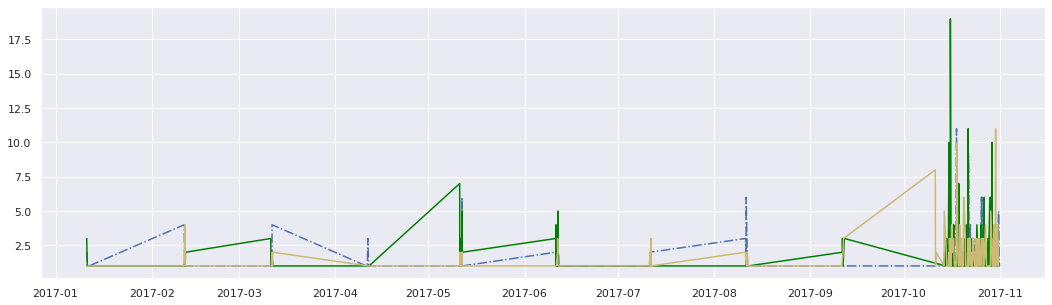

In [110]:
# значимых изменений в приросте пользователей не было обнаружено за исследуемый промежуток
plt.plot(B_joined_at.joined_at, B_joined_at.B,linestyle='-.')
plt.plot(A1_joined_at.joined_at, A1_joined_at.A1, color='green')
plt.plot(A2_joined_at.joined_at, A2_joined_at.A2, color='y')

In [120]:
# посмотрим изменилось ли число транзакиий по продукту, может стали больше монет покупать? или подписок?
A2_frame.product_type.value_counts()

coins               120
premium_no_trial    107
trial_premium        53
other_type           43
Name: product_type, dtype: int64

In [119]:
A1_frame.product_type.value_counts()

coins               137
premium_no_trial    106
trial_premium        67
other_type           46
Name: product_type, dtype: int64

In [118]:
# каких то значимых отличий не было обнаружено - значений мало - делать визуализацию нет смысла
B_frame.product_type.value_counts()

coins               101
premium_no_trial     76
trial_premium        62
other_type           27
Name: product_type, dtype: int64

# Заключение

В целом проведенный эксперимент можно считать успешным, но стоит внести ряд поправок, на тот счет, что данные были не совсем корректными. Главная проблема в данных - это разные страны, хотя это главная фича для раскатки, также размерность данных, группы получились хоть и сопоставимы, но вопросы по качеству эксперемента все таки остаеются. Различия между контрольными и тестовой группой иммеются, поэтому все цели, которые были поставлены является выполнены. Если рассматривать группы пользователей, по котором удалось провести поверхностный анализ, то получилась следующая картина:
- Франция и ОАЭ является ключевыми странами где тестирование прошло успешно, также успешны оказались Испания и США, хотя в группах они не совпали, но их тоже можно посчитать. Объяснение этого простое - все страны за последние 20 лет активно развивались и в них есть большой спрос на технологические продукты(к примеру тот же Чили не попал в рейтинг)
- В качестве возраста удалось выделить группу от 19 до 35 лет, в отличии от других групп у них уже есть финансовая независимость и им проще всего принять нововведения в отличии от более возрастной группы, где сделать это гораздо сложнее. Но третья группа также имеет смысл, для раскатки, но для этого нужно производить более детально демографическое исследования, так как группы могут разница от стране к стране.
- В качестве пола будет выступать только гендер - 1, так как исходные данные содержать в большинстве случаев информацию только о данном поле. Возможно это направленность приложения такая или проблема в выборке пола, достоверно узнать невозможно, но преобладает по массе своей именно 1 гендер.
- По типу подписки, также хотелось бы узнать, к какой группе обрезаться, но результаты показались различными и можно выделять только такие группы как: trial_premium, premium_no_trial (там в двух группах результаты получились положительные )

Рекомендация: перепровести тест, основываясь на корретных данных. Так как глубокий анализ пользователей в данном случая, может трактоваться некоректно. Лучше сбалансировать группы по полу, странам и количеству и повторить эксперемент в одном временном диапазоне.